## DNA Classification uing Classifiers

In this notebook, we will use different classification models that can predict a gene's function based on the DNA sequence of the coding sequence alone.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


### We have some data for human DNA sequence coding regions and a class label.  We also have data for Chimpanzee and a more divergent species, the dog.

In [3]:
chimp_data = pd.read_table('chimp_data.txt')
dog_data = pd.read_table('dog_data.txt')
chimp_data.head()
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


### Here are the definitions for each of the 7 classes and how many there are in the human training data.  They are gene sequence function groups.

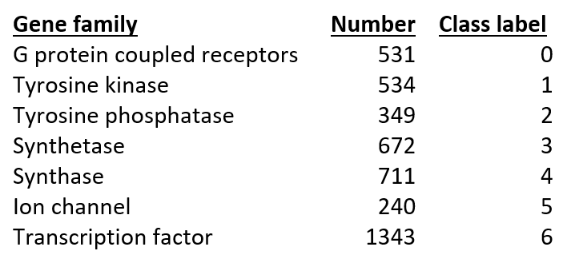

In [4]:
from IPython.display import Image
Image("Capture1.PNG")

### Converting to k-mers

A challenge for us is to convert these DNA sequences to vectors of uniform length since it is a requirement for feeding data to a classification or regression algorithm. So we need to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

The method we use here is simple and easy. We first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here we are using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. 

### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [5]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

## Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [6]:
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)
chimp_data['words'] = chimp_data.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_data.drop('sequence', axis=1)
dog_data['words'] = dog_data.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_data.drop('sequence', axis=1)

### Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step.  Let's take a look.

In [7]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


### Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.  We can also make a y variable to hold the class labels.  Let's do that now.

In [8]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values                         

In [9]:
print(human_texts[0])

atgccc tgcccc gcccca ccccaa cccaac ccaact caacta aactaa actaaa ctaaat taaata aaatac aatact atacta tactac actacc ctaccg taccgt accgta ccgtat cgtatg gtatgg tatggc atggcc tggccc ggccca gcccac cccacc ccacca caccat accata ccataa cataat ataatt taatta aattac attacc ttaccc tacccc accccc ccccca ccccat cccata ccatac catact atactc tactcc actcct ctcctt tcctta ccttac cttaca ttacac tacact acacta cactat actatt ctattc tattcc attcct ttcctc tcctca cctcat ctcatc tcatca catcac atcacc tcaccc caccca acccaa cccaac ccaact caacta aactaa actaaa ctaaaa taaaaa aaaaat aaaata aaatat aatatt atatta tattaa attaaa ttaaac taaaca aaacac aacaca acacaa cacaaa acaaac caaact aaacta aactac actacc ctacca taccac accacc ccacct caccta acctac cctacc ctacct tacctc acctcc cctccc ctccct tccctc ccctca cctcac ctcacc tcacca caccaa accaaa ccaaag caaagc aaagcc aagccc agccca gcccat cccata ccataa cataaa ataaaa taaaaa aaaaat aaaata aaataa aataaa ataaaa taaaaa aaaaaa aaaaat aaaatt aaatta aattat attata ttataa tataac ataaca taacaa aacaaa acaaac

In [10]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

## We will perform the same steps for chimpanzee and dog

In [11]:
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       # y_c for chimp

dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values   

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [12]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [13]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


### If we have a look at class balance we can see we have relatively balanced dataset.

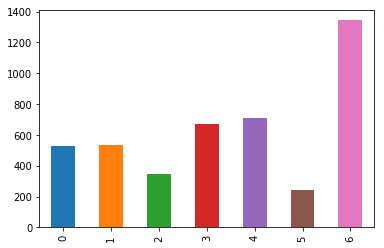

In [14]:
human_data['class'].value_counts().sort_index().plot.bar()

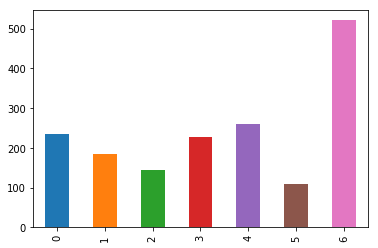

In [15]:
chimp_data['class'].value_counts().sort_index().plot.bar()

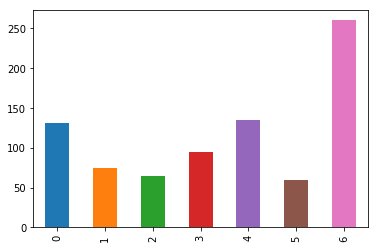

In [16]:
dog_data['class'].value_counts().sort_index().plot.bar()

### So now that we know how to transform our DNA sequences into uniform length numerical vectors in the form of k-mer counts and ngrams, we can now go ahead and build a classification model that can predict the DNA sequence function based only on the sequence itself.
Here we will use the human data to train the model, holding out 20% of the human data to test the model.
### So below we will - 1: train/test spit. 2: Build classifiers and 3: test the model performance

In [17]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [19]:
## Now that we have our dataset, we can start building algorithms! We'll need to import each algorithm we plan on using
# from sklearn.  We also need to import some performance metrics, such as accuracy_score and classification_report.

from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

In [20]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

### A classifier will be created. Now let's make predictions on the human hold out test set and see how it performes on unseen data.
### Also, let's us look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score.

In [21]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print('MultinomialNB')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
print(classification_report(y_test, y_pred))

MultinomialNB
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       102
           1       1.00      0.98      0.99       106
           2       1.00      1.00      1.00        78
           3       0.99      0.99      0.99       125
           4       0.99      0.96      0.98       149
           5       1.00      1.00      1.00        51
           6       0.96      0.99      0.98       265

   micro avg       0.98      0.98      0.98       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.98      0.98      0.98       876



In [22]:
classifier = MLPClassifier(alpha = 1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print('Neural Net')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
print(classification_report(y_test, y_pred))

Neural Net
accuracy = 0.952 
precision = 0.954 
recall = 0.952 
f1 = 0.952
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       102
           1       1.00      0.94      0.97       106
           2       1.00      0.94      0.97        78
           3       0.89      0.97      0.93       125
           4       0.95      0.93      0.94       149
           5       1.00      0.92      0.96        51
           6       0.94      0.98      0.96       265

   micro avg       0.95      0.95      0.95       876
   macro avg       0.96      0.94      0.95       876
weighted avg       0.95      0.95      0.95       876



### Let's see how our model perfoms on the DNA sequences from other species. First we'll try the Chimpanzee, which we would expect to be very similar to human. Then we will try man's (and woman's) best friend, the Dog DNA sequences.

In [23]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_chimp)
accuracy, precision, recall, f1 = get_metrics(y_chimp, y_pred)
print('MultinomialNB')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
print(classification_report(y_chimp, y_pred))

MultinomialNB
accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       234
           1       1.00      0.99      1.00       185
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00       228
           4       1.00      0.97      0.99       261
           5       1.00      1.00      1.00       109
           6       0.98      1.00      0.99       521

   micro avg       0.99      0.99      0.99      1682
   macro avg       1.00      0.99      0.99      1682
weighted avg       0.99      0.99      0.99      1682



In [24]:
classifier = MLPClassifier(alpha = 1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_chimp)
accuracy, precision, recall, f1 = get_metrics(y_chimp, y_pred)
print('Neural Net')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
print(classification_report(y_chimp, y_pred))

Neural Net
accuracy = 0.989 
precision = 0.989 
recall = 0.989 
f1 = 0.989
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       234
           1       0.98      1.00      0.99       185
           2       1.00      1.00      1.00       144
           3       0.98      0.99      0.98       228
           4       0.99      0.97      0.98       261
           5       1.00      0.99      1.00       109
           6       0.99      0.99      0.99       521

   micro avg       0.99      0.99      0.99      1682
   macro avg       0.99      0.99      0.99      1682
weighted avg       0.99      0.99      0.99      1682



In [25]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_dog)
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred)
print('MultinomialNB')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
print(classification_report(y_dog, y_pred))

MultinomialNB
accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       131
           1       1.00      0.84      0.91        75
           2       1.00      0.77      0.87        64
           3       0.99      0.85      0.92        95
           4       0.96      0.93      0.95       135
           5       1.00      0.88      0.94        60
           6       0.85      1.00      0.92       260

   micro avg       0.93      0.93      0.93       820
   macro avg       0.96      0.89      0.92       820
weighted avg       0.93      0.93      0.93       820



In [26]:
classifier = MLPClassifier(alpha = 1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_dog)
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred)
print('Neural Net')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
print(classification_report(y_dog, y_pred))

Neural Net
accuracy = 0.944 
precision = 0.948 
recall = 0.944 
f1 = 0.943
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       131
           1       0.99      0.95      0.97        75
           2       1.00      0.94      0.97        64
           3       0.92      0.96      0.94        95
           4       0.99      0.83      0.90       135
           5       1.00      0.85      0.92        60
           6       0.91      1.00      0.95       260

   micro avg       0.94      0.94      0.94       820
   macro avg       0.96      0.93      0.94       820
weighted avg       0.95      0.94      0.94       820

